<a href="https://colab.research.google.com/github/palberth/Modelos_y_Metodos_de_Sistemas_Inteligentes/blob/main/Regresion_Precios_Autos_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

np.random.seed(42)
tf.random.set_seed(42)


In [4]:
##url = "https://raw.githubusercontent.com/selva86/datasets/master/UsedCars.csv"

df = pd.read_csv("/content/used_cars_dataset_v2.csv", on_bad_lines='skip', encoding='latin-1')

print("Dimensiones:", df.shape)
df.head()


Dimensiones: (14993, 11)


,Brand,model,Year,Age,kmDriven,Transmission,Owner,FuelType,PostedDate,AdditionInfo,AskPrice
0,Honda,City,2001,23,"98,000 km",Manual,second,Petrol,Nov-24,"Honda City v teck in mint condition, valid gen...","â¹ 1,95,000"
1,Toyota,Innova,2009,15,190000.0 km,Manual,second,Diesel,Jul-24,"Toyota Innova 2.5 G (Diesel) 7 Seater, 2009, D...","â¹ 3,75,000"
2,Volkswagen,VentoTest,2010,14,"77,246 km",Manual,first,Diesel,Nov-24,"Volkswagen Vento 2010-2013 Diesel Breeze, 2010...","â¹ 1,84,999"
3,Maruti Suzuki,Swift,2017,7,"83,500 km",Manual,second,Diesel,Nov-24,Maruti Suzuki Swift 2017 Diesel Good Condition,"â¹ 5,65,000"
4,Maruti Suzuki,Baleno,2019,5,"45,000 km",Automatic,first,Petrol,Nov-24,"Maruti Suzuki Baleno Alpha CVT, 2019, Petrol","â¹ 6,85,000"


In [9]:
# Clean 'kmDriven' column
df['kmDriven'] = df['kmDriven'].astype(str).str.replace(' km', '').str.replace(',', '')
df['kmDriven'] = pd.to_numeric(df['kmDriven'], errors='coerce')

# Clean 'AskPrice' column
df['AskPrice'] = df['AskPrice'].astype(str).str.replace('â\x82¹', '').str.replace(',', '')
df['AskPrice'] = pd.to_numeric(df['AskPrice'], errors='coerce')

# Drop rows with NaN values created by coercion
df.dropna(subset=['kmDriven', 'AskPrice'], inplace=True)

print("Data types after cleaning:")
print(df[['kmDriven', 'AskPrice']].dtypes)
print("\nFirst 5 rows after cleaning:")
print(df[['kmDriven', 'AskPrice']].head())

Data types after cleaning:
kmDriven    float64
AskPrice      int64
dtype: object

First 5 rows after cleaning:
   kmDriven  AskPrice
0   98000.0    195000
1  190000.0    375000
2   77246.0    184999
3   83500.0    565000
4   45000.0    685000


In [10]:
numeric_features = ['Year', 'kmDriven']
categorical_features = ['Brand', 'model', 'FuelType']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])
print(df.columns)
X = df[numeric_features + categorical_features]
y = df['AskPrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

input_dim = X_train_processed.shape[1]

Index(['Brand', 'model', 'Year', 'Age', 'kmDriven', 'Transmission', 'Owner',
       'FuelType', 'PostedDate', 'AdditionInfo', 'AskPrice'],
      dtype='object')


In [11]:
model = Sequential([
    Dense(128, activation='relu', input_dim=input_dim, kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        60,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,609 (268.00 KB)

 Trainable params: 68,609 (268.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5)

history = model.fit(
    X_train_processed, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)


Epoch 1/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 3507796049920.0000 - mae: 983986.0000 - val_loss: 3621758959616.0000 - val_mae: 1004501.1875 - learning_rate: 0.0010
Epoch 2/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3498765713408.0000 - mae: 979790.0000 - val_loss: 3589421400064.0000 - val_mae: 989748.6875 - learning_rate: 0.0010
Epoch 3/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3456387776512.0000 - mae: 959752.3125 - val_loss: 3507660783616.0000 - val_mae: 951612.9375 - learning_rate: 0.0010
Epoch 4/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3363972579328.0000 - mae: 914730.9375 - val_loss: 3373236486144.0000 - val_mae: 885852.5000 - learning_rate: 0.0010
Epoch 5/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3222327001088.0000 - mae: 841753.8750 - val_loss: 3198254317568.0000 - val_mae: 795933.8125 - learning_rate: 0.0010
Epoch 6/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3048873132032.0000 - mae: 748800.0000 - val_loss: 300

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test MSE: 1067425988608.00
Test MAE: 306783.28
Test R² Score: 0.59


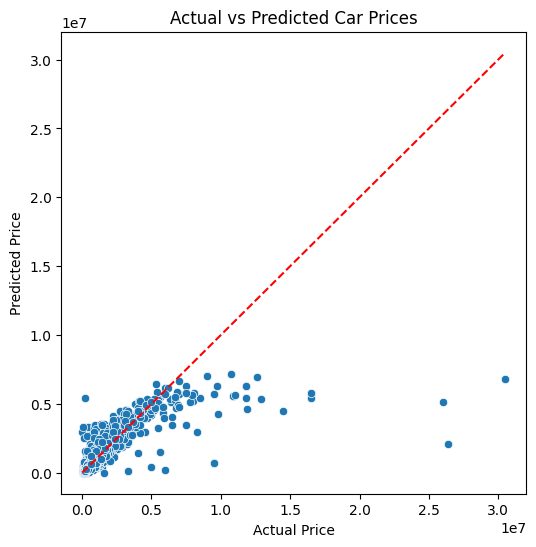

In [13]:
y_pred = model.predict(X_test_processed).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R² Score: {r2:.2f}")

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.show()
